In [3]:
from matplotlib import pyplot as plt
import pandas as pd
import uproot
import torch
import numpy as np
from matplotlib.ticker import FuncFormatter
import itertools

### Plot True

In [7]:
# Define data_min and data_max 
data_min = torch.tensor([-2000, -2000, 0, -2000], dtype=torch.float32)
data_max = torch.tensor([2000, 2000, 60, 2000], dtype=torch.float32)

def _normalize(data):
    return (data - data_min) / (data_max - data_min)

def plotTrue(n_dim, slice_dim_x1=0, slice_dim_x2=1, slice_value=0.5):
        '''Plot the True Function with a Heatmap'''

        # Open the ROOT file
        file = uproot.open('/u/dvoss/al_pmssmwithgp/Run3ModelGen/source/Run3ModelGen/scans/scan_true4D/ntuple.0.0.root')
        
        tree_name = "susy"
        tree = file[tree_name]
        
        # Convert tree to pandas DataFrame
        df = tree.arrays(library="pd")

        base_order = ["IN_M_1", "IN_M_2", "IN_tanb", "IN_mu", "IN_M3", "IN_AT", "IN_Ab", "IN_Atau", 
                      "IN_mA", "IN_meL", "IN_mtauL", "IN_meR", "IN_mtauR", "IN_mqL1", "IN_mqL3", 
                      "IN_muR", "IN_mtR", "IN_mdR", "IN_mbR"]
        order = {i: base_order[:i] for i in range(1, len(base_order) + 1)}
        
        # Get the parameters to include based on n
        selected_columns = order.get(n_dim, None)

        # Apply the mask to filter only valid Omega values
        Omega = df['MO_Omega']
        mask = Omega > 0
        filtered_data = {param: df[f"{param}"][mask] for param in selected_columns}
        filtered_data['MO_Omega'] = Omega[mask]  # Always include Omega for filtering

        # Construct the limited DataFrame dynamically with only the selected columns
        limited_df = pd.DataFrame(filtered_data)

        # Convert to tensors
        x_true = torch.stack([torch.tensor(limited_df[param].values, dtype=torch.float32) for param in selected_columns], dim=1)
        x_true = _normalize(x_true)
        y_true = torch.log(torch.tensor(limited_df['MO_Omega'].values, dtype=torch.float32) / 0.12)
        

        # Determine the remaining dimensions to plot
        remaining_dims = [dim for dim in range(n_dim) if dim != slice_dim_x1 and dim != slice_dim_x2]

        # Set the remaining dimensions to the slice value
        for dim in remaining_dims:
            indices = (x_true[:, dim].cpu().numpy() >= slice_value) & (x_true[:, dim].cpu().numpy() <= slice_value)
            filtered_x_true = x_true[indices, :]
            filtered_y_true = y_true[indices]

        heatmap, xedges, yedges = np.histogram2d(filtered_x_true[:, slice_dim_x1].numpy(), filtered_x_true[:, slice_dim_x2].numpy(), bins=50, weights=filtered_y_true.cpu().numpy())
        heatmap_counts, xedges, yedges = np.histogram2d(filtered_x_true[:, slice_dim_x1].numpy(), filtered_x_true[:, slice_dim_x2].numpy(), bins=50)
        heatmap = heatmap/heatmap_counts

        plt.figure(figsize=(8, 6))
        plt.imshow(heatmap.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='inferno', aspect='auto')
        plt.colorbar(label='log(Omega/0.12)')

        # # Scatterplot of the training points
        # plt.scatter(filtered_x_true[:, slice_dim_x1].numpy(), filtered_x_true[:, slice_dim_x2].numpy(), marker='o', s=50, c=filtered_y_true.numpy(), cmap='inferno', label='true points')

        # Labels for the dimensions
        labels = {
            0: "M_1_normalized",
            1: "M_2_normalized",
            2: "M_3_normalized",
            3: "tanb_normalized",
            4: "mu_normalized",
            5: "AT_normalized",
            6: "Ab_normalized",
            7: "Atau_normalized",
            8: "mA_normalized",
            9: "meL_normalized",
            10: "mtauL_normalized",
            11: "meR_normalized",
            12: "mtauR_normalized",
            13: "mqL1_normalized",
            14: "mqL3_normalized",
            15: "muR_normalized",
            16: "mtR_normalized",
            17: "mdR_normalized",
            18: "mbR_normalized"
        }
        plt.xlabel(labels[slice_dim_x1])
        plt.ylabel(labels[slice_dim_x2])

        plt.show()

/tmp/ipykernel_135180/1433522137.py:54: RuntimeWarning: invalid value encountered in divide
  heatmap = heatmap/heatmap_counts


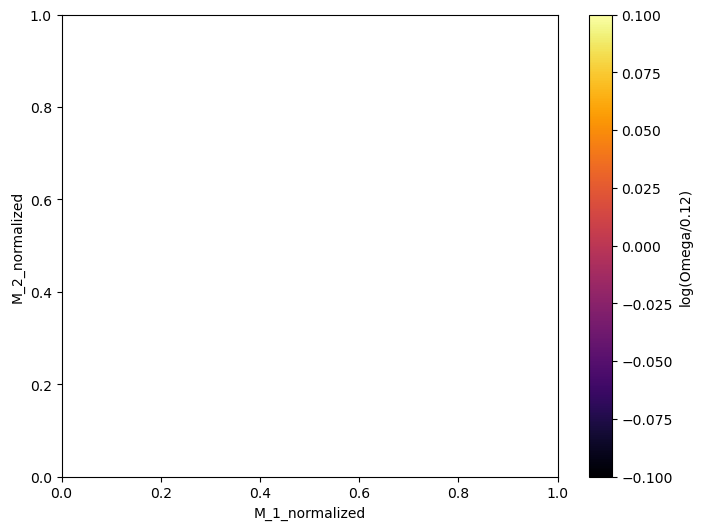

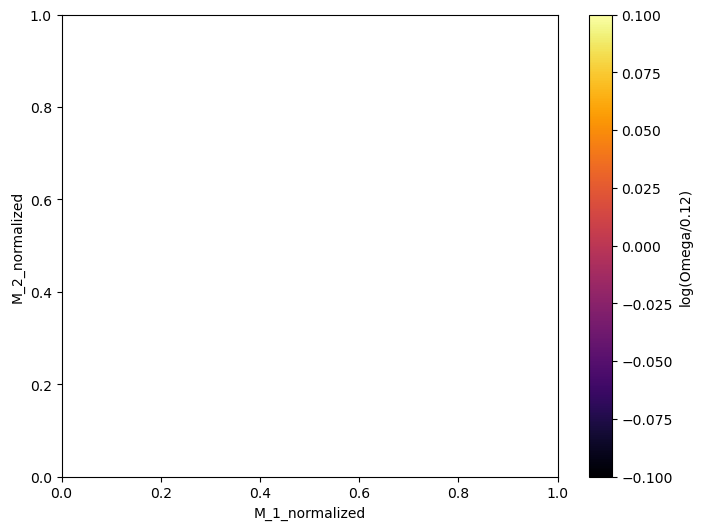

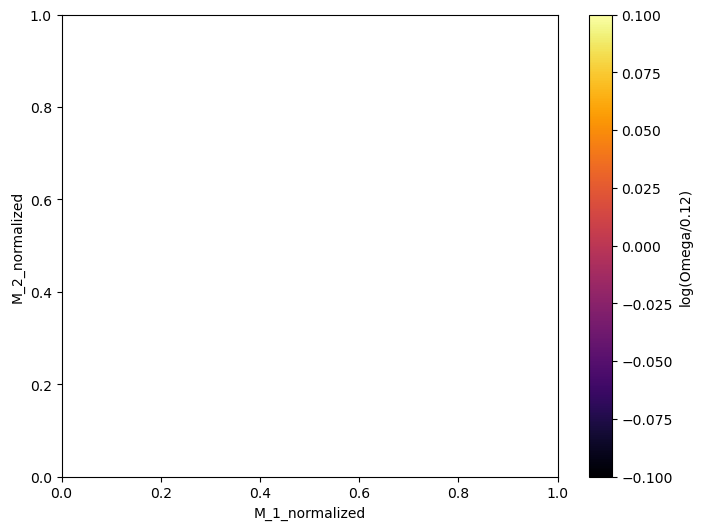

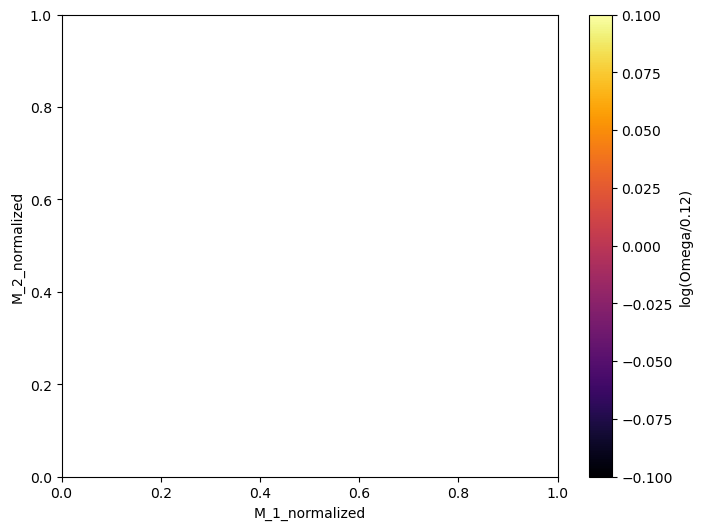

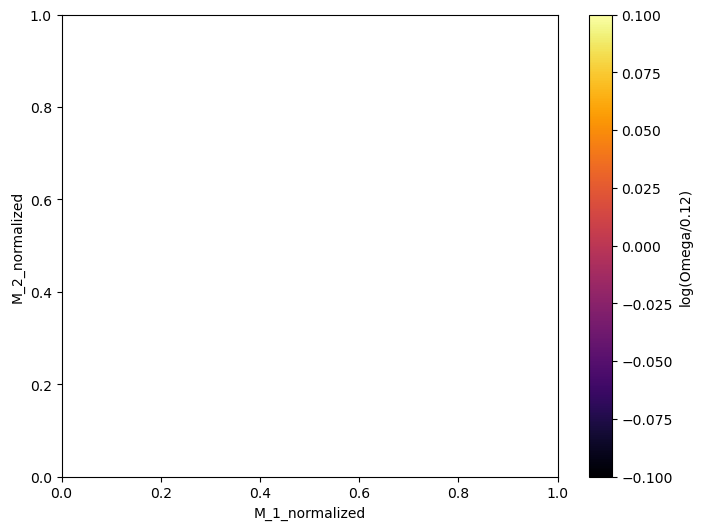

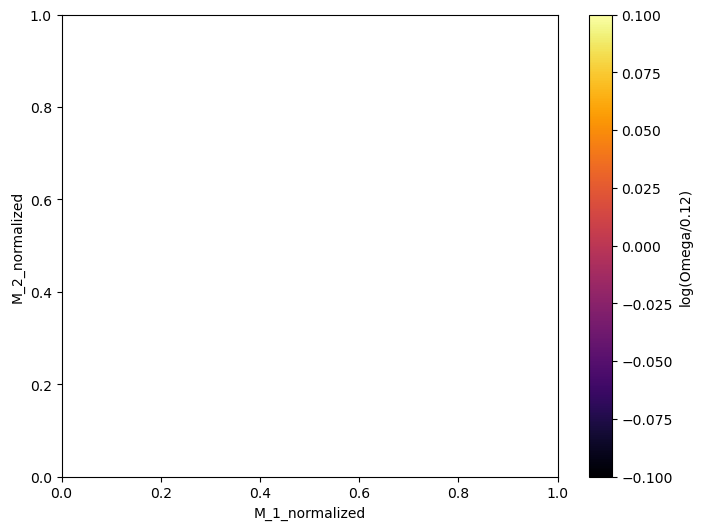

In [8]:
n_dim = 4
# Generate all possible combinations of two dimensions from n_dim for plotting
combinations = list(itertools.combinations(range(n_dim), 2))

for (slice_dim_x1, slice_dim_x2) in combinations:
    plotTrue(n_dim, slice_dim_x1=0, slice_dim_x2=1, slice_value=0.5)

### Weighted Metric Plots

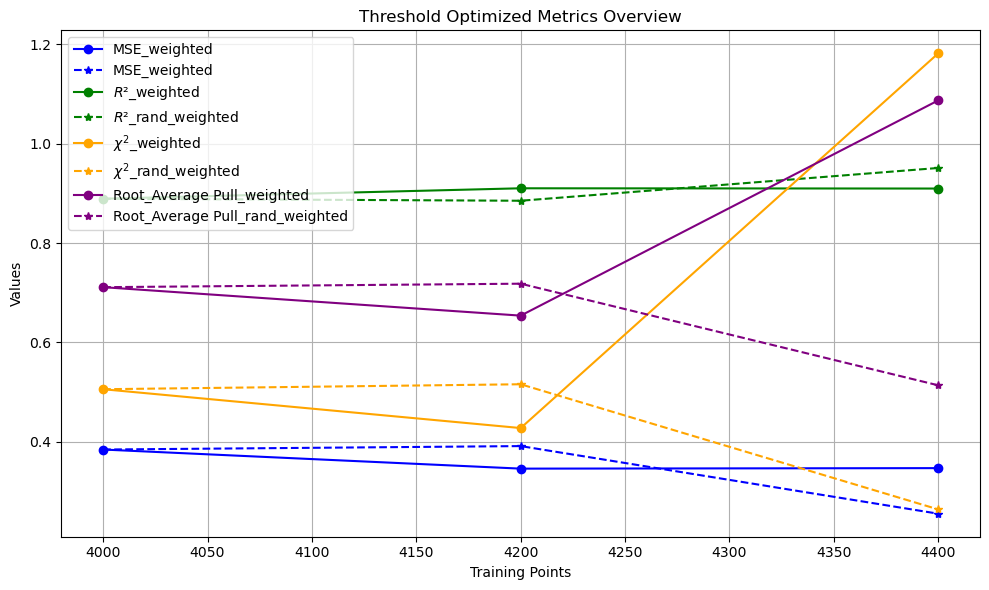

In [11]:
df = pd.read_csv('gof_4000.csv')
df_rand = pd.read_csv('gof_4000_rand.csv')

# Erstellen eines einzigen Plots mit allen Metriken und einer Legende
plt.figure(figsize=(10, 6))

# # Plot für mean_squared_0 und mean_squared_1
plt.plot(df.index, df['mean_squared_weighted_1']*10, label='MSE_weighted', marker='o', color='blue')
plt.plot(df_rand.index, df_rand['mean_squared_weighted_1']*10, label='MSE_weighted', marker='*', color='blue', linestyle='--')

# Plot für r_squared
plt.plot(df.index, df['r_squared_weighted'], label='$R²$_weighted', marker='o', color='green')
plt.plot(df_rand.index, df_rand['r_squared_weighted'], label='$R²$_rand_weighted', marker='*', color='green', linestyle='--')

# Plot für chi_squared_0 und chi_squared_1
plt.plot(df.index, df['chi_squared_weighted_0'], label='$\chi^2$_weighted', marker='o', color='orange')
plt.plot(df_rand.index, df_rand['chi_squared_weighted_0'], label='$\chi^2$_rand_weighted', marker='*', color='orange', linestyle='--')

# # Plot für average_pull_0 und average_pull_1
plt.plot(df.index, df['average_pull_weighted_1']*100, label='Root_Average Pull_weighted', marker='o', color='purple')
plt.plot(df_rand.index, df_rand['average_pull_weighted_1']*100, label='Root_Average Pull_rand_weighted', marker='*', color='purple', linestyle='--')

# Titel und Legende hinzufügen
plt.title('Threshold Optimized Metrics Overview')
plt.xlabel('Training Points')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

# X-Achse um den Faktor 10 skalieren
def x_tick_formatter(x, pos):
    return f'{x * 200 + 4000:.0f}'  # Multipliziert die x-Werte mit 10 und entfernt Dezimalstellen

plt.gca().xaxis.set_major_formatter(FuncFormatter(x_tick_formatter))

# Plot anzeigen
plt.tight_layout()
plt.show()

### Metric Plots

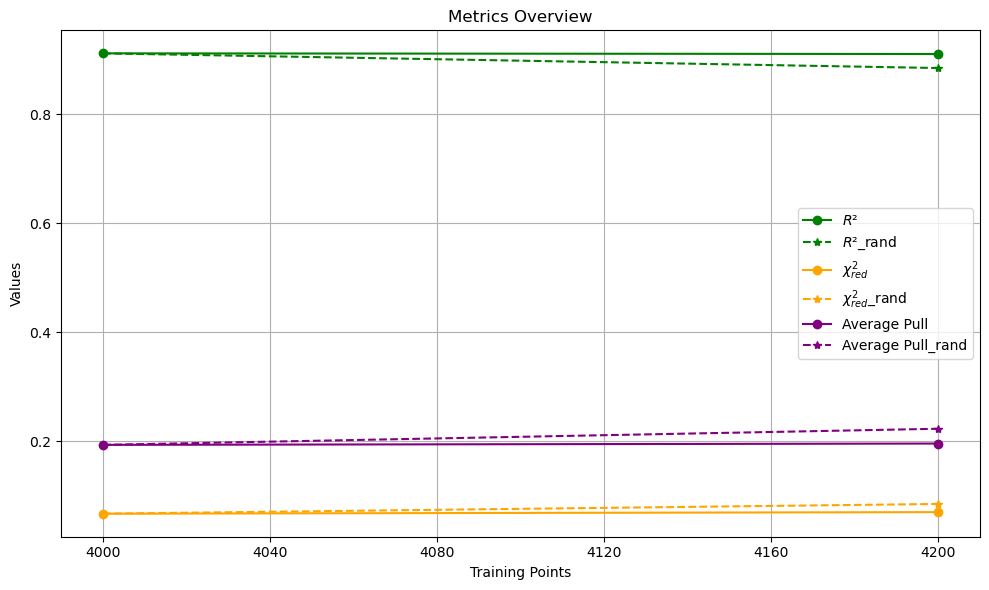

In [15]:
df = pd.read_csv('gof_4000.csv')
df = df[:2]
df_rand = pd.read_csv('gof_4000_rand.csv')
df_rand = df_rand[:2]

# Erstellen eines einzigen Plots mit allen Metriken und einer Legende
plt.figure(figsize=(10, 6))

# Plot für mean_squared_0 und mean_squared_1
#plt.plot(df.index, df['mean_squared_0'], label='mean_squared_0', marker='o')
# plt.plot(df.index, df['mean_squared_1'], label='mean_squared_1', marker='o')

# Plot für r_squared
plt.plot(df.index, df['r_squared'], label='$R²$', marker='o', color='green')
plt.plot(df_rand.index, df_rand['r_squared'], label='$R²$_rand', marker='*', color='green', linestyle='--')

# Plot für chi_squared_0 und chi_squared_1
#plt.plot(df.index, df['chi_squared_0'], label='chi_squared_0', marker='o', color='red')
plt.plot(df.index, df['chi_squared_1'], label='$\chi_{red}^2$', marker='o', color='orange')
plt.plot(df_rand.index, df_rand['chi_squared_1'], label='$\chi_{red}^2$_rand', marker='*', color='orange', linestyle='--')


# Plot für average_pull_0 und average_pull_1
plt.plot(df.index, df['average_pull_0'], label='Average Pull', marker='o', color='purple')
plt.plot(df_rand.index, df_rand['average_pull_0'], label='Average Pull_rand', marker='*', color='purple', linestyle='--')
#plt.plot(df.index, df['average_pull_1'], label='average_pull_1', marker='o', color='brown')

# Titel und Legende hinzufügen
plt.title('Metrics Overview')
plt.xlabel('Training Points')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

# X-Achse um den Faktor 10 skalieren
def x_tick_formatter(x, pos):
    return f'{x * 200 + 4000:.0f}'  # Multipliziert die x-Werte mit 10 und entfernt Dezimalstellen

plt.gca().xaxis.set_major_formatter(FuncFormatter(x_tick_formatter))

# Plot anzeigen
plt.tight_layout()
plt.show()

In [4]:
path = '/u/dvoss/al_pmssmwithgp/Run3ModelGen/source/Run3ModelGen/scans/scan_true/ntuple.0.0.root'

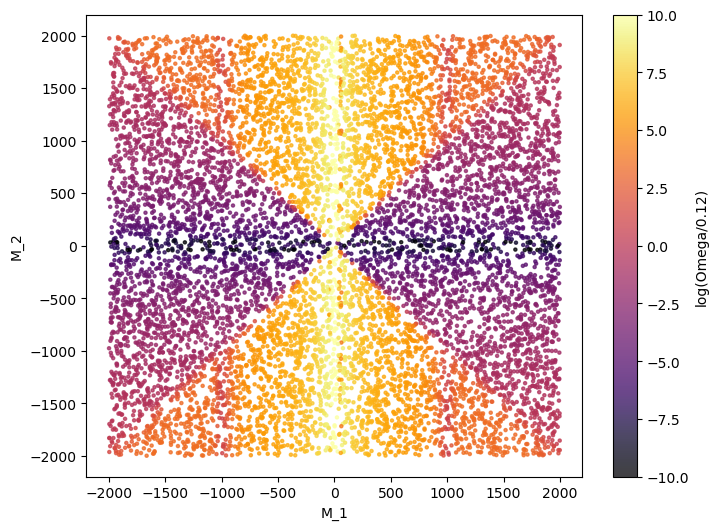

In [48]:
def plotTrue(path):
        '''Plot the 2D GP with a Heatmap and the new points and save it in the plot folder'''

        # Open the ROOT file
        file = uproot.open(path)
        
        tree_name = "susy"
        tree = file[tree_name]
        
        # Convert tree to pandas DataFrame
        df = tree.arrays(library="pd")

        M_1 = df['IN_M_1'].values
        M_2 = df['IN_M_2'].values
        Omega = df['MO_Omega'].values

        # Create a mask to filter out negative or zero values of Omega
        mask = Omega > 0

        # Apply the mask to filter M_1, M_2, and Omega
        M_1_filtered = M_1[mask]
        M_2_filtered = M_2[mask]
        Omega_filtered = Omega[mask]

        # Calculate the true values (log-scaled)
        true = torch.log(torch.tensor(Omega_filtered, dtype=torch.float32) / 0.12)
        
        # heatmap, xedges, yedges = np.histogram2d(M_1_filtered, M_2_filtered, bins=50, weights=true.cpu().numpy())
        # heatmap_counts, xedges, yedges = np.histogram2d(M_1_filtered, M_2_filtered, bins=50)
        # heatmap = heatmap/heatmap_counts

        plt.figure(figsize=(8, 6))
        #plt.imshow(heatmap.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='inferno', aspect='auto')
        plt.scatter(M_1_filtered, M_2_filtered, vmin=-10, vmax=10, c=true.cpu().numpy(), cmap='inferno', s=5, alpha=0.75)
        plt.colorbar(label='log(Omega/0.12)')
        plt.xlabel('M_1')
        plt.ylabel('M_2')

        plt.show()


plotTrue(path)


(10000,) (10000,) (10000,)


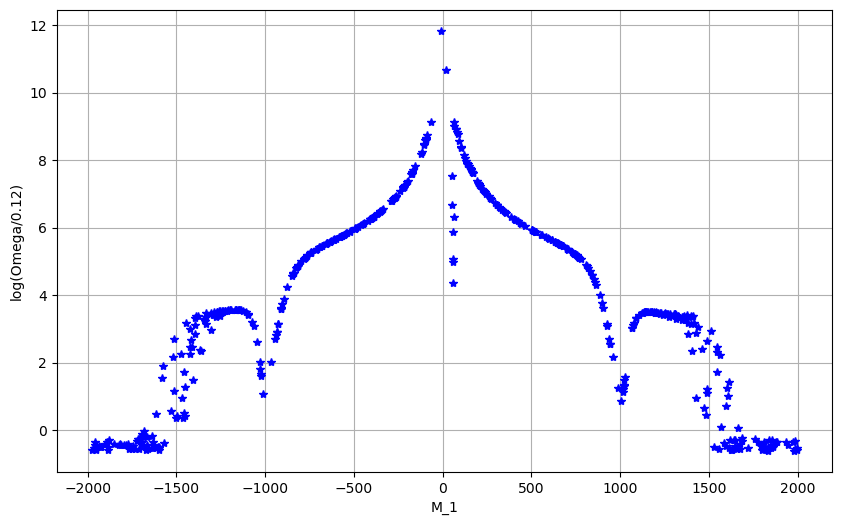

In [61]:
def plotSlice1D(slice_dim=0, slice_value=1000, tolerance=0.01, path = None):

        # Start plotting
        fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
        
        ax1.set_xlabel(f'M_{"2" if slice_dim == 0 else "1"}')
        ax1.set_ylabel('log(Omega/0.12)')
        ax1.grid(True)

        # Plot true data points
        if path:
            # Open the ROOT file
            file = uproot.open(path)
            tree_name = "susy"
            tree = file[tree_name]
            
            # Convert tree to pandas DataFrame
            df = tree.arrays(library="pd")
            M_1_filtered = df['IN_M_1']
            M_2_filtered = df['IN_M_2']
            Omega = df['MO_Omega']
            mask = Omega > 0
            Omega_filtered = Omega#[mask]

            print(M_1_filtered.shape, M_2_filtered.shape, Omega_filtered.shape)

            # Normalize the true data
            if slice_dim == 0:
                indices_true = np.where((M_1_filtered >= slice_value - tolerance) & (M_1_filtered <= slice_value + tolerance))[0] # Creates tuple from which we take the first index
                x_true = M_2_filtered[indices_true] # Is marginalized along M_1, so M_2 is x_coordinate
            else:
                indices_true = np.where((M_2_filtered >= slice_value - tolerance) & (M_2_filtered <= slice_value + tolerance))[0]
                x_true = M_1_filtered[indices_true] # Is marginalized along M_2, so M_1 is x_coordinate
            y_true = torch.log(torch.tensor(Omega_filtered.values, dtype=torch.float32) / 0.12).cpu().numpy()
            y_true = y_true[indices_true]
            ax1.plot(x_true, y_true, '*', c='b', label = 'True Function')

            plt.show()

plotSlice1D(slice_dim=1, slice_value=1500, tolerance=100, path=path)

### Check content of root file

In [9]:
# Open the ROOT file
file = uproot.open(path)

tree_name = "susy"
tree = file[tree_name]

# Convert tree to pandas DataFrame
df = tree.arrays(library="pd")

# Find all columns, which contain 
columns = [col for col in df.columns if 'tanb' in col]

print(columns)

['IN_tanb', 'SP_tanb_min', 'SP_tanb_ext', 'SS_tanb_min', 'SS_tanb_ext']


### Two Circles

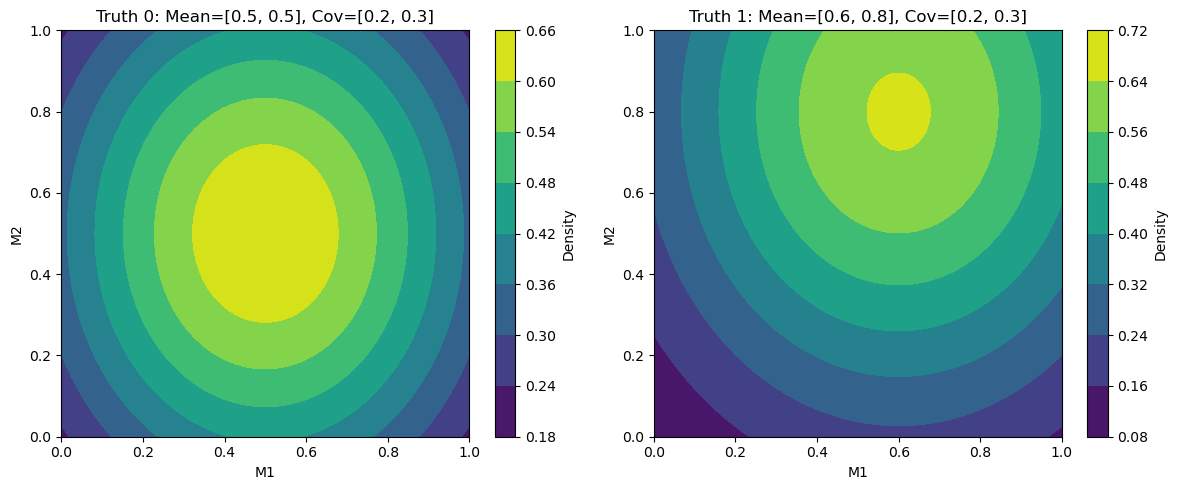

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Definiere den Bereich
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
positions = np.dstack((X, Y))

# Truth-Funktionen
truth0 = multivariate_normal(mean=[0.5, 0.5], cov=np.diag([0.2, 0.3]))
truth1 = multivariate_normal(mean=[0.6, 0.8], cov=np.diag([0.2, 0.3]))

# Werte berechnen
Z0 = truth0.pdf(positions)
Z1 = truth1.pdf(positions)

# Plots
plt.figure(figsize=(12, 5))

# Plot truth0
plt.subplot(1, 2, 1)
plt.contourf(X, Y, Z0, cmap="viridis")
plt.colorbar(label="Density")
plt.title("Truth 0: Mean=[0.5, 0.5], Cov=[0.2, 0.3]")
plt.xlabel("M1")
plt.ylabel("M2")

# Plot truth1
plt.subplot(1, 2, 2)
plt.contourf(X, Y, Z1, cmap="viridis")
plt.colorbar(label="Density")
plt.title("Truth 1: Mean=[0.6, 0.8], Cov=[0.2, 0.3]")
plt.xlabel("M1")
plt.ylabel("M2")

plt.tight_layout()
plt.show()


### Toy Model Two Circles

Initial Training Points:
X: tensor([[0.0235, 0.9642],
        [0.8433, 0.6886],
        [0.6327, 0.3706],
        [0.1262, 0.0851],
        [0.7266, 0.1366],
        [0.4472, 0.5316],
        [0.9699, 0.2345],
        [0.2595, 0.4162],
        [0.3648, 0.7233],
        [0.5195, 0.8397]])
Y: tensor([0.2707, 0.5489, 0.6046, 0.3439, 0.4586, 0.6442, 0.3326, 0.5557, 0.5712,
        0.6376])
Iteration 1/10
Model training completed.


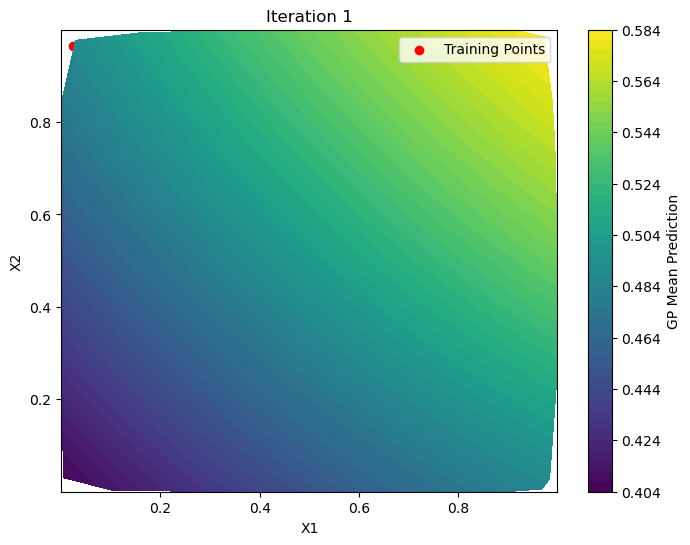

Iteration 2/10
Model training completed.


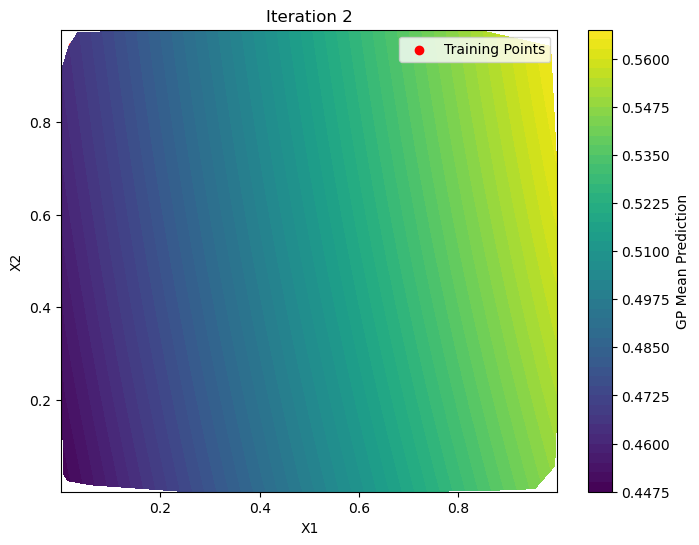

Iteration 3/10
Model training completed.


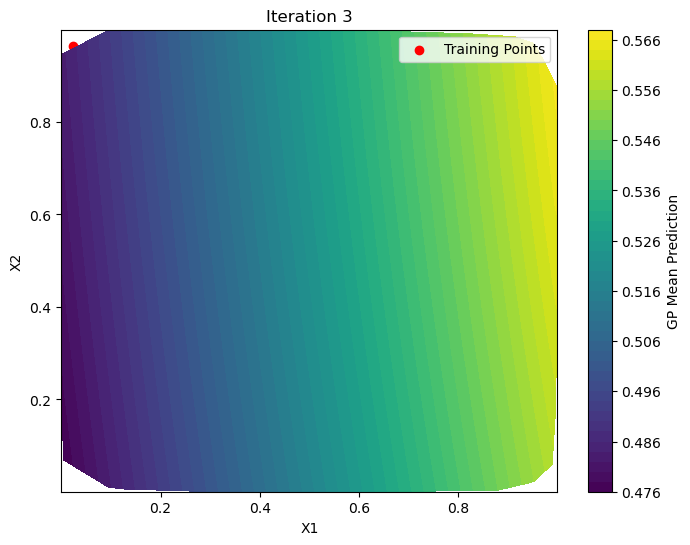

Iteration 4/10
Model training completed.


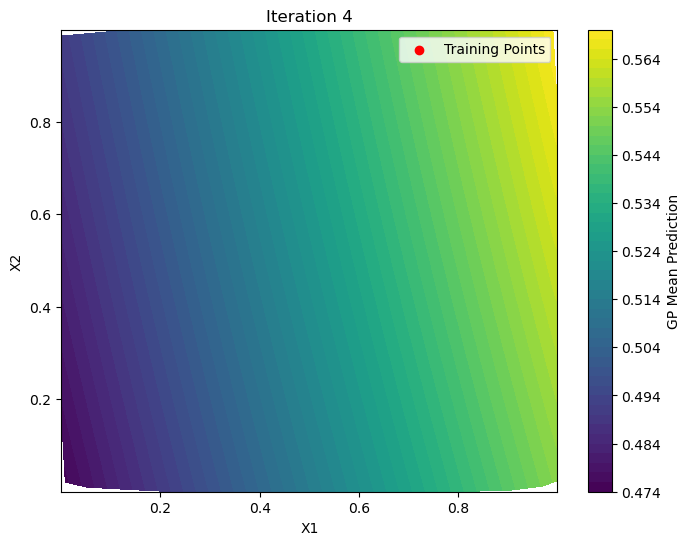

Iteration 5/10
Model training completed.


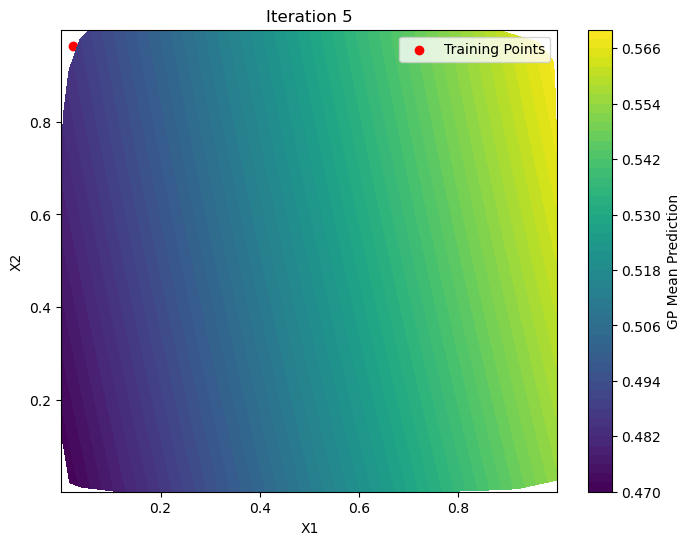

Iteration 6/10


In [ ]:
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.models import ExactGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.distributions import MultivariateNormal
from scipy.stats import multivariate_normal


class GPRegressionModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)


class GPModelPipeline:
    def __init__(self, initial_points=10, iterations=10, points_per_iter=3):
        # Define device (CPU or GPU)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.likelihood = GaussianLikelihood().to(self.device)
        self.model = None
        self.iterations = iterations
        self.points_per_iter = points_per_iter

        # Define the truth function
        self.truth = lambda X: np.maximum(
            multivariate_normal.pdf(X, mean=[0.5, 0.5], cov=np.diag([0.2, 0.3])),
            multivariate_normal.pdf(X, mean=[0.6, 0.8], cov=np.diag([0.2, 0.3]))
        )
        self.threshold = 0.5

        # Generate initial training data
        self._initialize_training_data(initial_points)

    def _initialize_training_data(self, initial_points):
        sampler = qmc.LatinHypercube(d=2)
        initial_samples = sampler.random(n=initial_points)
        self.x_train = torch.tensor(initial_samples, dtype=torch.float32).to(self.device)
        self.y_train = torch.tensor(
            self.truth(initial_samples), dtype=torch.float32
        ).to(self.device)

        print(f"Initial Training Points:\nX: {self.x_train}\nY: {self.y_train}")

    def initialize_model(self):
        self.model = GPRegressionModel(self.x_train, self.y_train, self.likelihood).to(self.device)
        self.optimizer = torch.optim.Adam([
            {'params': self.model.parameters()},
        ], lr=0.1)
        self.mll = ExactMarginalLogLikelihood(self.likelihood, self.model)

    def train_model(self, iters=50):
        self.model.train()
        self.likelihood.train()

        for i in range(iters):
            self.optimizer.zero_grad()
            output = self.model(self.x_train)
            loss = -self.mll(output, self.y_train)
            loss.backward()
            self.optimizer.step()

        print("Model training completed.")

    def evaluate_model(self, x_test):
        self.model.eval()
        self.likelihood.eval()

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            predictions = self.likelihood(self.model(x_test))
            mean = predictions.mean
            lower, upper = predictions.confidence_region()
            return mean, lower, upper

    def select_new_points(self):
        # Generate candidate points using Latin Hypercube sampling
        sampler = qmc.LatinHypercube(d=2)
        candidate_points = torch.tensor(sampler.random(n=1000), dtype=torch.float32).to(self.device)

        # Evaluate the model
        mean, _, _ = self.evaluate_model(candidate_points)
        scores = torch.abs(mean - self.threshold)  # Find points close to the threshold
        top_indices = torch.topk(scores, self.points_per_iter, largest=False).indices
        return candidate_points[top_indices]

    def plot_predictions(self, x_test, mean, iteration):
        plt.figure(figsize=(8, 6))
        plt.scatter(self.x_train[:, 0].cpu(), self.x_train[:, 1].cpu(), c='red', label="Training Points")
        plt.tricontourf(
            x_test[:, 0].cpu(), x_test[:, 1].cpu(), mean.cpu().numpy(), levels=50, cmap='viridis'
        )
        plt.colorbar(label="GP Mean Prediction")
        plt.title(f"Iteration {iteration + 1}")
        plt.xlabel("X1")
        plt.ylabel("X2")
        plt.legend()
        plt.show()

    def run_pipeline(self):
        self.initialize_model()
        for iteration in range(self.iterations):
            print(f"Iteration {iteration + 1}/{self.iterations}")
            self.train_model()

            # Evaluate the model
            x_test = torch.tensor(
                qmc.LatinHypercube(d=2).random(n=1000), dtype=torch.float32
            ).to(self.device)
            mean, _, _ = self.evaluate_model(x_test)

            # Plot the predictions
            self.plot_predictions(x_test, mean, iteration)

            # Select new points
            new_points = self.select_new_points()
            new_values = torch.tensor(
                self.truth(new_points.cpu().numpy()), dtype=torch.float32
            ).to(self.device)

            # Update training data
            self.x_train = torch.cat([self.x_train, new_points], dim=0)
            self.y_train = torch.cat([self.y_train, new_values], dim=0)

            # Update the model with the new training data
            self.model.set_train_data(inputs=self.x_train, targets=self.y_train, strict=False)


if __name__ == "__main__":
    pipeline = GPModelPipeline(initial_points=10, iterations=10, points_per_iter=3)
    pipeline.run_pipeline()
